# Amazon Mechanical Turk

The role of this script is to generate the data in a format that we can use to label on Mechanical Turk

1. Generate the next batch
2. Read the batch and write it to MongoDB

In [1]:
from data.dao import DataAccess, LabelGetter
from data.turk import TurkResults2Label

import pandas as pd
import datetime
import re
import pickle
import numpy

%matplotlib inline

Getting the data from DataAccess is so easy!

In [2]:
%%time

X = DataAccess.get_not_labeled().sort("random_number")
X.head(10)

CPU times: user 1.37 s, sys: 1.38 s, total: 2.75 s
Wall time: 12.9 s


In [3]:
X_filter = X[X.control != 1]
X_filter.head()

,control,predict,random_number,text
_id,,,,
556e8debd6dfbb3061976b0e,NaN,0.215714,0.004196,My #TeenChoice nominee for #ChoiceMaleWebStar ...
5575d384d6dfbb66f9dac606,NaN,0.194029,0.004235,#TweetMyJobs #Accounting #Job alert: Senior Ac...
5572131ed6dfbb33bf90487d,NaN,0.338928,0.004239,"Never imagined myself saying this 3 years ago,..."
5572b598d6dfbb719b60fb40,NaN,0.411088,0.004250,Who made me drink &amp; why?
557849c1d6dfbb56c0b31675,NaN,0.258357,0.004261,".@BilldeBlasio Opposes Linking Tax Credit, Ren..."


In [4]:
X_control = X[X.control == 1]
X_control.head()

,control,predict,random_number,text
_id,,,,
5584b355d6dfbb636c07fba4,1,NaN,NaN,Now that's a malty hop punch. Great bitterness...
558ded7dd6dfbb1d49557f3f,1,NaN,NaN,5star Friday continues after a delay.... - Dri...
557a3d92d6dfbb59f52789b3,1,NaN,NaN,"Late check-in, perfect hot as balls day crisp ..."
556ba263d6dfbb336fb8c141,1,NaN,NaN,Drinking a Rams Head IPA by @FoDoBrewing @ Bar...
556ba2c8d6dfbb336fb8c582,1,NaN,NaN,Drinking a Summerweisse by @BottleLogicBrew at...


In [5]:
len(X_filter)

81122

In [6]:
len(X_control)

483

# Preprocessing

In [157]:
from __private import fs
from classification.dao import ClassifierAccess

In [158]:
fs.list()

['alcohol|accuracy:0.8143360752056404|f1:0.8192219679633866|type:LogisticRegression',
 'alcohol|accuracy:0.8401880141010576|f1:0.8498896247240618|type:SVC',
 'alcohol|accuracy:0.8425381903642774|f1:0.8562231759656651|type:RandomForestClassifier',
 'first_person_label|accuracy:0.5637860082304527|f1:0.5574430033343769|type:SVC',
 'first_person_label|accuracy:0.5637860082304527|f1:0.5643693591852614|type:LogisticRegression',
 'first_person|accuracy:0.6951871657754011|f1:0.8034482758620688|type:RandomForestClassifier',
 'first_person|accuracy:0.7005347593582888|f1:0.7751004016064257|type:LogisticRegression',
 'first_person|accuracy:0.7032085561497327|f1:0.8062827225130889|type:RandomForestClassifier',
 'first_person|accuracy:0.7112299465240641|f1:0.8021978021978021|type:SVC']

In [66]:
alcohol_classifier = ClassifierAccess.get_byfile(
    "alcohol|accuracy:0.8401880141010576|f1:0.8498896247240618|type:SVC"
)

firstperson_classifier = ClassifierAccess.get_byfile(
    "first_person|accuracy:0.7112299465240641|f1:0.8021978021978021|type:SVC"
)

firstpersonlevel_classifier = ClassifierAccess.get_byfile(
    "first_person_label|accuracy:0.5637860082304527|f1:0.5643693591852614|type:LogisticRegression"
)

In [197]:
X = X.sample(10000)

In [198]:
%%time

first_person = firstperson_classifier.predict_proba(X)[:,1]
alch_labels = alcohol_classifier.predict_proba(X)[:,1]

CPU times: user 1min 43s, sys: 5.63 s, total: 1min 49s
Wall time: 1min 55s


In [201]:
X["predicted_fp"] = first_person
X["predicted_alc"] = alch_labels

ValueError: Length of values does not match length of index

In [202]:
X = X[
    ~(X.text.str.contains("Drinking a"))
]

In [203]:
X["score"] = (X.predicted_alc * X.predicted_fp)

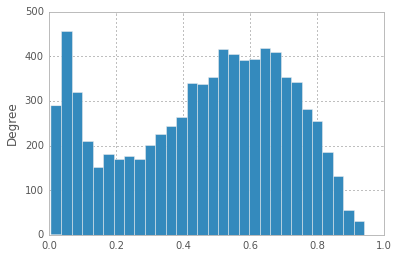

In [204]:
X.score.plot(kind="hist", bins=30)

In [205]:
X.random_number = X.text.apply(hash)

In [206]:
len(X)

8155

# Generating...

In [212]:
date = str(datetime.date.today())
candidate = X.sort("random_number").head(3000)
key = candidate.random_number.sum()

In [213]:
candidate["text"] = candidate.text.str.encode("utf-8")

In [214]:
candidate[["text", "random_number"]].to_csv(
    "../amt/c_amt|{}|{}.csv".format(date, key),
)

In [215]:
%%bash

ls ../amt/

Batch_2055156_batch_results.csv
Batch_2064123_batch_results.csv
Batch_2064125_batch_results.csv
Batch_2101169_batch_results.csv
Batch_2164917_batch_results.csv
Batch_2166655_batch_results.csv
Batch_2248153_batch_results.csv
amt_2015-08-13_4952308500878643456.csv
amt_2015-08-17_2546340314496401664.csv
amt_2015-08-20_8806137010034599936.csv
amt_2015-09-10_6072541214091395328.csv
amt_2015-09-24_-7976654553505407232.csv
amt|2015-09-10|6072541214091395328.csv
amt|2015-09-24|-7976654553505407232.csv
amt|2015-11-16|-6308615403510686754.csv
amt|2015-11-16|-81244987503678735.csv
amt|2015-11-16|287544318312245760.csv
c_amt_2015-11-16_-6269207037782773504.csv
c_amt_2015-11-16_7954396760112903981.csv
c_amt_2016-01-21_-8087639176019565329_2.csv
c_amt_2016-01-21_5520759830824576334.csv
c_amt_2016-01-29_7647127386955943697_2000.csv
c_amt_2016-01-30_-7432510530338082686.txt
c_amt_2016-01-31_0.1315425978524588_rest_of_control.csv
c_amt_2016-02-02_nan.csv
c_amt|2015-11-16|7954396760112903981.csv
c_amt|2

In [216]:
%%bash

open .. 

# Parsing to Label

#### New Labels

Straight from Amazon Mechanical Turk

In [165]:
df = pd.DataFrame.from_csv("/Users/JasonLiu/Downloads/Batch_2251572_batch_results.csv")
# df = pd.DataFrame.from_csv("/Users/JasonLiu/Downloads/Batch_2239372_batch_results.csv")

In [166]:
df.Worker.value_counts().head(10)

AM7FYVGVOEP66     165
AS9E0S6DBSWH7     131
A2WNW8A4MOR7T7    108
A22634OVAX2IVC    100
A2CGAOF4G65D67     88
A1I8952MLVA6SL     60
A1GKEEI844CEKI     42
A1T79J0XQXDDGC     38
AI885RNRGVIFM      36
AJPQEZBVJXVE9      30
dtype: int64

In [171]:
df[["text", "Answer"]].head()

,text,Answer
_id,,
5571d508d6dfbb1a6ee6355d,"b""Guess what we'll have for dessert tonight......",Not Alcohol Related
5590767dd6dfbb3e78051738,"b""So, @theopenbottleco is having a #cider nigh...",Alcohol Related::Promotional Content
558537ced6dfbb0db12641fa,"b""With her wine stained lips yeah she's nothin...",Alcohol Related::Discussion
559064f3d6dfbb3733208919,b'little east coast love this morning with a r...,Not Alcohol Related
55824824d6dfbb2fcd1af933,b'@AshBennett23 yeah passed tf out off this Ch...,First Person - Alcohol::Heavy Drinking


In [173]:
df = df[df.Worker != "A2AFTOA85C1FM9"]
df = df[df.Answer != "Alcohol Related"]

In [174]:
df.Answer.value_counts()

Not Alcohol Related                               397
First Person - Alcohol::Casual Drinking           136
Alcohol Related::Promotional Content              100
Alcohol Related::Discussion                       100
First Person - Alcohol::Looking to drink           63
First Person - Alcohol::Reflecting on drinking     53
First Person - Alcohol::Heavy Drinking             23
dtype: int64

In [ ]:
# df = df.set_index("_id")

#### Writing Labels using TurkResults2Label

In [176]:
%%time
DataAccess.write_labels(df.Answer.apply(TurkResults2Label.parse_to_labels))

CPU times: user 980 ms, sys: 449 ms, total: 1.43 s
Wall time: 1min 39s


In [177]:
disc = X_control[
    (X_control.predicted_alc < 0.2)
    ] 

AttributeError: 'DataFrame' object has no attribute 'predicted_alc'

In [148]:
disc["Answer"] = "Not Alcohol Related"

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [149]:
disc.sample(5)

,control,predict,random_number,text,predicted_fp,predicted_alc,Answer
_id,,,,,,,
5591763cd6dfbb4e77e28bb8,1,NaN,NaN,"Talk about being, ""Fogged in"". This is way!! P...",0.552012,0.190272,Not Alcohol Related
5587acd4d6dfbb4182ae5fb0,1,NaN,NaN,@AlexandSierra @thehotelcafe but I'm not 21 😢😢😢😢,0.578864,0.096895,Not Alcohol Related
558304bed6dfbb6115f00829,1,NaN,NaN,#grill afternoon with coworkers of @victorfrog...,0.509105,0.069019,Not Alcohol Related
558e27bed6dfbb4c990cb9d5,1,NaN,NaN,"I'm at @CoveLoungeNyc in New York, NY https://...",0.635797,0.168464,Not Alcohol Related
558dc188d6dfbb024ceb651e,1,NaN,NaN,amazing show last night! thanks for coming out...,0.686985,0.106364,Not Alcohol Related


In [150]:
DataAccess.write_labels(disc.Answer.apply(TurkResults2Label.parse_to_labels))